# TI3130: Classification &mdash; Exercises
**Julián Urbano and Jing Sun &mdash; January 2024**

In [2]:
import sys
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

python 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)] 
numpy 1.26.1 
pandas 2.1.3 
plotnine 0.12.4 
statsmodels 0.14.0 
sklearn 1.3.2


For these exercises we will use the _Amsterdam Lite_ and _Heart_ datasets. Please refer to their HTML files for a description of the variables.

In [3]:
def obj2cat(df):
    for col in df.select_dtypes('object').columns:
        df[col] = pd.Categorical(df[col])
    return df

ams = obj2cat(pd.read_csv('amsterdam_lite.csv'))
heart = obj2cat(pd.read_csv('heart.csv'))

We will also use the evaluation metrics and cross-validation code we used in the tutorial:

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# to display confusion matrices in the notebook
%matplotlib inline
from sklearn.model_selection import StratifiedKFold

    
def kfold_cv(X, y, k, H, cv_fun, random_state):
    """
    Do stratified k-fold cross-validation with a dataset, to check how a model behaves as a function
    of the values in H (eg. a hyperparameter such as tree depth, or polynomial degree).

    :param X: feature matrix.
    :param y: response column.
    :param k: number of folds.
    :param H: values of the hyperparameter to cross-validate.
    :param cv_fun: function of the form (X_train, y_train, X_valid, y_valid, h) to evaluate the model in one split,
        as a function of h. It must return a dictionary with metric score values.
    :param random_state: controls the pseudo random number generation for splitting the data.
    :return: a Pandas dataframe with metric scores along values in H.
    """
    kf = StratifiedKFold(n_splits = k, shuffle = True, random_state = random_state)
    scores = []  # to store global results

    # for each value h in H, do CV
    for h in H:
        
        # for each fold 1..K
        kk = 0
        for train_index, valid_index in kf.split(X, y):
            kk = kk+1
            # partition the data in training and validation
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # call cv_fun to train the model and compute performance
            fold_scores = {'_h': h, '_fold': kk}
            fold_scores.update(cv_fun(X_train, y_train, X_valid, y_valid, h))
            scores.append(fold_scores)
            
    return pd.DataFrame(scores)

**1) The first classifier in the tutorial notebook used the logistic model `saf_neighbors ~ hou_value` with a default threshold of 0.5. Use the cross-validation function to perform 10-fold cross-validation to chose the optimal threshold, with a tolerance of 0.05. What is the threshold that optimizes the macro-averaged F-score?**

In [5]:
def cv_fun(X_train, y_train, X_valid, y_valid, h):
    # Create the model
    df_train = pd.DataFrame({'saf_neighbors': y_train, 'hou_value': X_train})
    m = smf.glm('saf_neighbors ~ hou_value', df_train, family = sm.families.Binomial()).fit()
    # Calculate predictions
    p = m.predict(X_valid)
    p = (p > h).astype(int)
    # compute and return evaluation metric scores
    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro')}

y = ams['saf_neighbors'].cat.codes
X = ams['hou_value']
k = 10 # 10 folds
H = np.arange(0, 1.05, 0.05) # Threshold with tolerance 0.05
pr = kfold_cv(X, y, k, H, cv_fun, random_state = 12345)
averaged_pr = pr \
    .groupby('_h') \
    .aggregate({'accuracy': 'mean', \
                'precision': 'mean', \
                'recall': 'mean', \
                'f': 'mean'})
max_f = averaged_pr.loc[averaged_pr['f'].idxmax()]
max_f = max_f.reset_index()
print(max_f)
# optimal threshold is 0.65


       index      0.65
0   accuracy  0.612253
1  precision  0.633127
2     recall  0.635633
3          f  0.603238


**2) Fit a tree model to predict `district` based on _all other_ categorical variables, and produce a full classification report with the training data. Is there any problem with this model, and if so, what is the cause?**

    accuracy  precision    recall         f
_h                                         
5   0.310105   0.211997  0.286837  0.230595
10  0.326829   0.263326  0.313520  0.273969
15  0.322067   0.274736  0.309779  0.276717
20  0.324506   0.276453  0.311820  0.280470
25  0.329384   0.281601  0.317432  0.285566
30  0.331707   0.284937  0.319813  0.287276
35  0.336527   0.294735  0.323895  0.292704
40  0.346225   0.295772  0.325765  0.294445
45  0.343844   0.294389  0.323724  0.292730


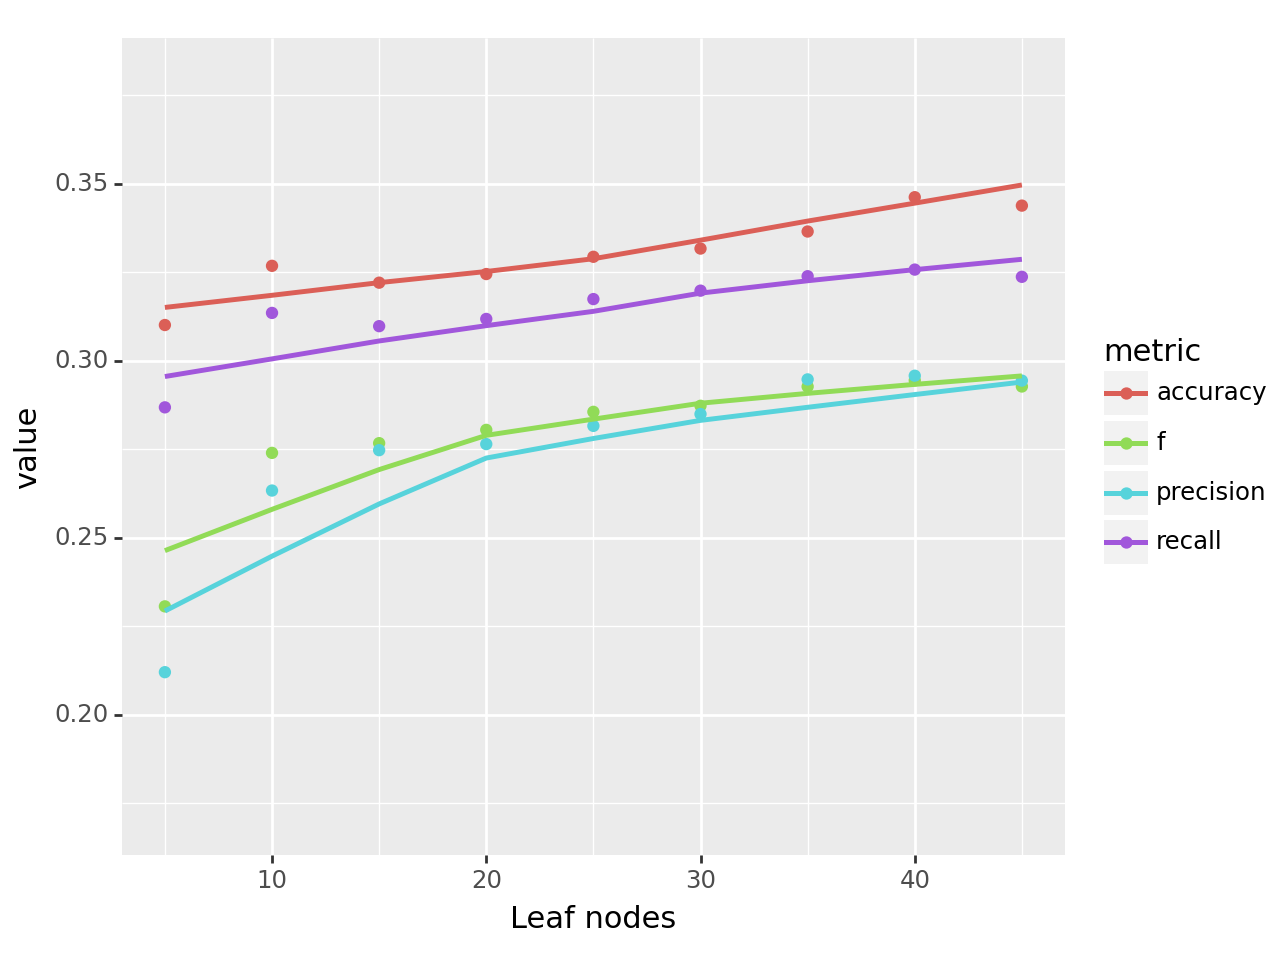

<Figure Size: (640 x 480)>

In [6]:
from sklearn import tree

def cv_tree_leaf(X_train, y_train, X_valid, y_valid, h):
    # fit tree pruned to h leaf nodes
    # we set the random state here as well for full reproducibility
    # this seed affects the learning process, not the data split
    m = tree.DecisionTreeClassifier(max_leaf_nodes = h, random_state = 54321).fit(X_train, y_train)  # fit the model with the training set
    
    # predict on the validation set
    p = m.predict(X_valid)

    # compute and return evaluation metric scores
    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro')}

y = ams['district'].cat.codes
X = ams.select_dtypes(include=['category'])
X = X.drop('district', axis=1)
X = pd.get_dummies(X, dtype = 'int')
k = 10 # 10 folds
H = range(5, 50, 5)
pr = kfold_cv(X, y, k, H, cv_tree_leaf, random_state = 12345)
averaged_pr = pr \
    .groupby('_h') \
    .aggregate({'accuracy': 'mean', \
                'precision': 'mean', \
                'recall': 'mean', \
                'f': 'mean'})
print(averaged_pr)
pr2 = pr.melt(id_vars = ['_h', '_fold'], var_name = 'metric')
ggplot(pr2, aes('_h', 'value', color = 'metric')) +\
    stat_summary(geom = 'point') +\
    geom_smooth(se = False) +\
    labs(x = 'Leaf nodes')

# all the metrics seem to have upward trend,
# meaning he model's performance increases with its complexity
# which should not be the case due to overfitting.

**3) Slide 34 shows an example of how complex models keep improving in the training set but not necessarily in a validation set because they eventually overfit. Use the _Heart_ dataset and decision trees to predict `ahd` with _all_ other features to produce a plot similar to the one in the slides via 10-fold cross-validation. You only need to plot accuracy in the training and validation sets. At what number of leaf nodes does the tree start overfitting?**

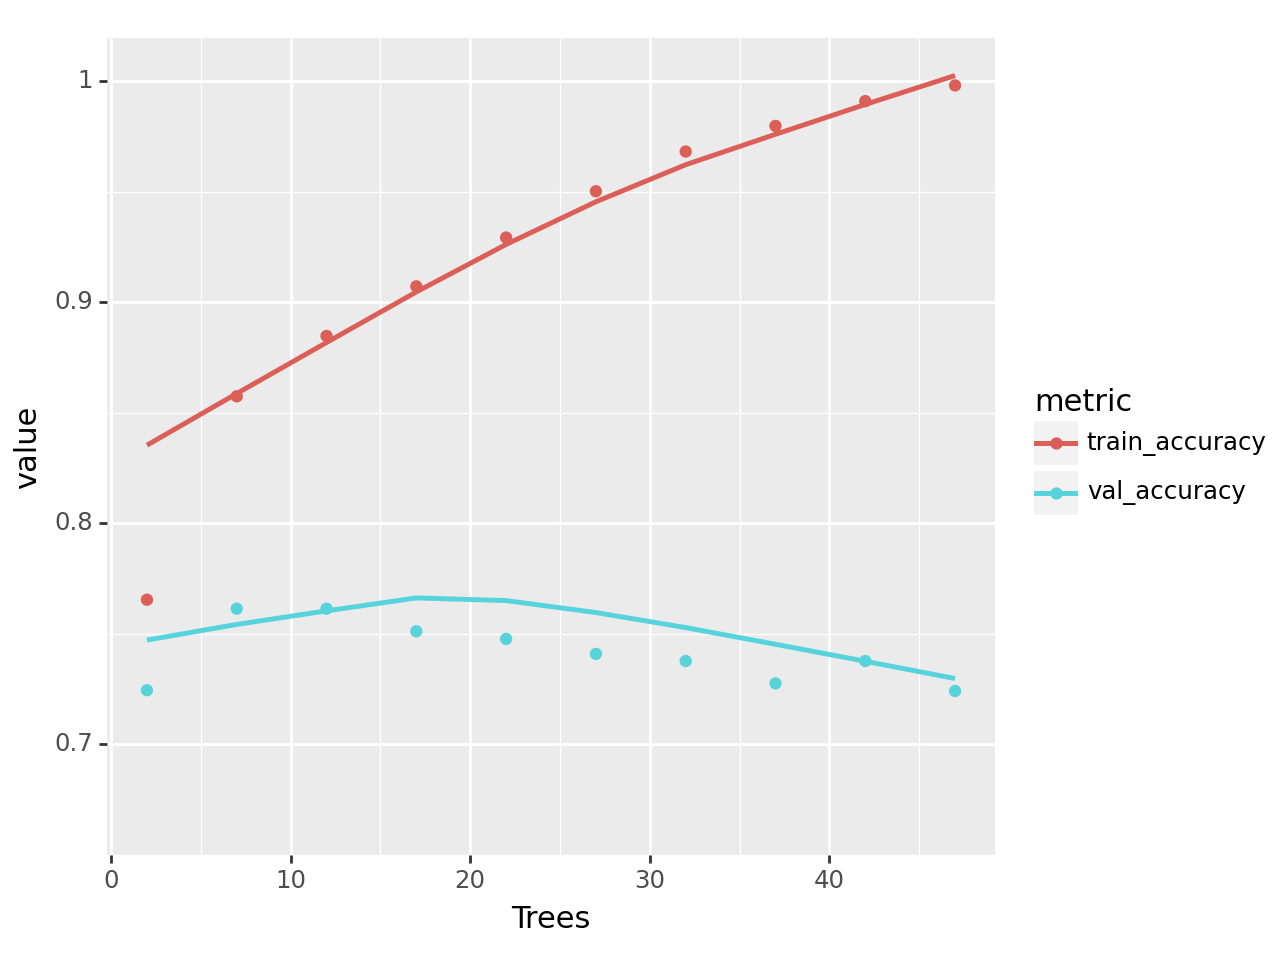

<Figure Size: (640 x 480)>

In [19]:
import matplotlib.pyplot as plt
from sklearn import tree

def cv_tree_leaf(X_train, y_train, X_valid, y_valid, h):
    # fit tree pruned to h leaf nodes
    # we set the random state here as well for full reproducibility
    # this seed affects the learning process, not the data split
    m = tree.DecisionTreeClassifier(max_leaf_nodes = h, random_state = 54321).fit(X_train, y_train)  # fit the model with the training set
    
    # Training accuracy
    train_p = m.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_p)

    # Validation accuracy
    val_p = m.predict(X_valid)
    val_accuracy = accuracy_score(y_valid, val_p)
    return {'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy}

    

y = heart['ahd'].cat.codes
X = heart.drop('ahd', axis=1)
X = pd.get_dummies(X)
k = 10 # 10 folds
H = range(2, 51, 5)
accuracy = kfold_cv(X, y, k, H, cv_tree_leaf, random_state = 12345) \
    .melt(id_vars = ['_h', '_fold'], var_name = 'metric')

ggplot(accuracy, aes('_h', 'value', color = 'metric')) +\
    stat_summary(geom = 'point') +\
    geom_smooth(se = False) +\
    labs(x = 'Trees')

**4) Use Scikit-learn's [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to build a model to predict `saf_nonneighbors` using all integer features in the dataset (you may have to increase the `max_iter` argument to something like `1000`). Produce a full classification report and confusion matrix.**

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       210
           1       0.67      0.64      0.65       203

    accuracy                           0.67       413
   macro avg       0.67      0.67      0.67       413
weighted avg       0.67      0.67      0.67       413



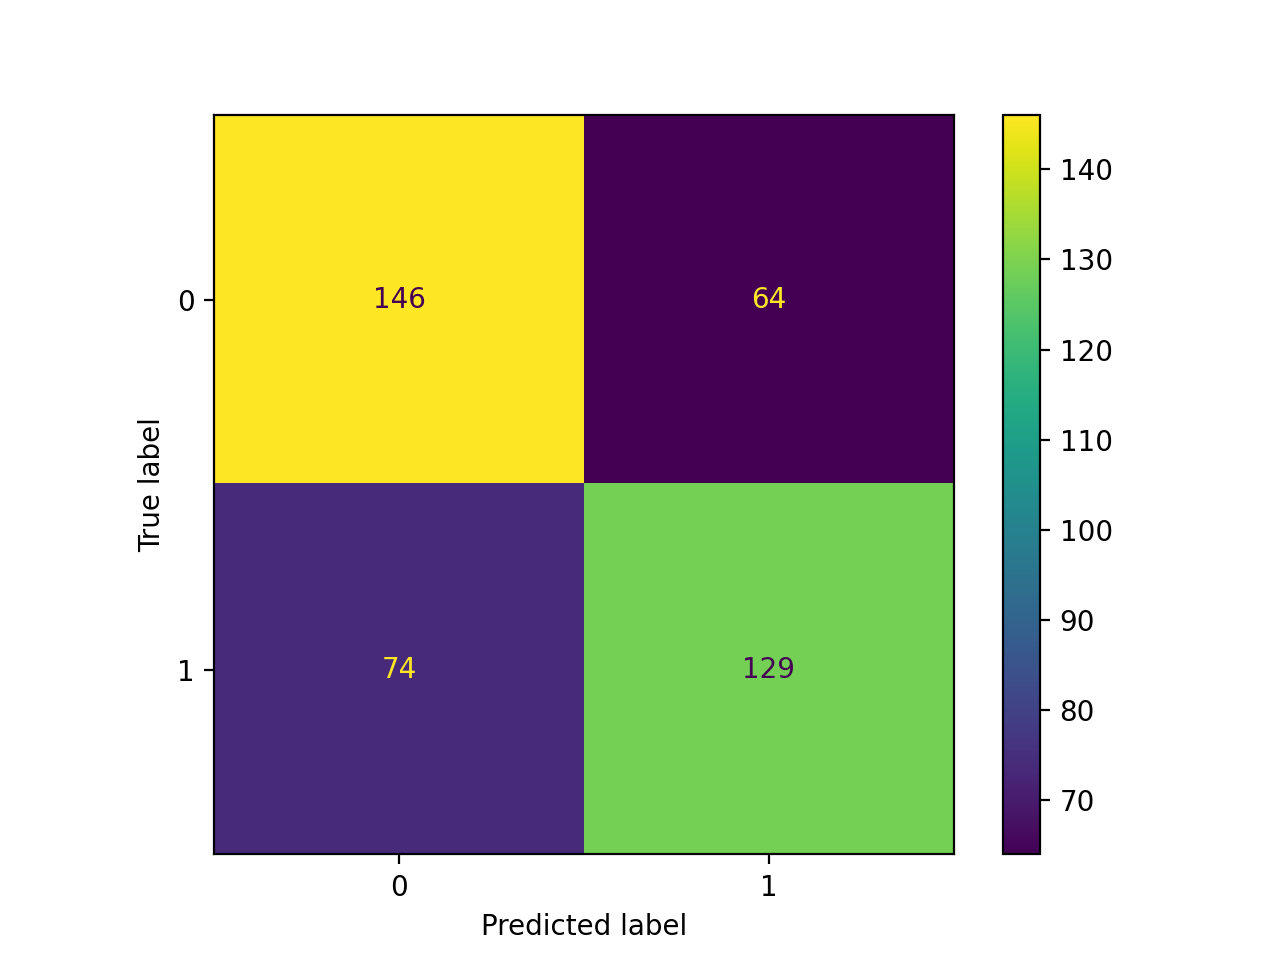

In [9]:
from sklearn.linear_model import LogisticRegression

y = ams['saf_nonneighbors'].cat.codes
X = ams.select_dtypes(include='int')
m = LogisticRegression(max_iter=1000).fit(X, y)
p = m.predict(X)
print(classification_report(y, p))
ConfusionMatrixDisplay.from_predictions(y, p)

**5) Implement function `bagging_fit` to fit a classification model through bagging of `ntree` decision trees. In order to perform random sampling with replacement (ie. _bootstrapping_) you can use function [`choices`](https://docs.python.org/3/library/random.html#random.choices) in library Random. For example, to sample `20` numbers with replacement from the sequence `0...9`, we do `choices(np.arange(0,10), k=20)`.**

In [21]:
from sklearn import tree
from random import choices

def bagging_fit(X, y, ntree = 10):
    trees = []
    
    # repeat ntree times: sample data and fit a tree
    for i in range(ntree):
        idx_train = choices(range(len(X)), k=len(X))
        X_train = X.iloc[idx_train]
        y_train = y.iloc[idx_train]
        m = tree.DecisionTreeClassifier().fit(X_train, y_train)
        trees.append(m)
            
    return trees

y = ams['spa_streets']
X = pd.get_dummies(ams.filter(regex = '^(fac_|inc_|saf_)'))
bagging_fit(X, y)

[DecisionTreeClassifier(),
 DecisionTreeClassifier(),
 DecisionTreeClassifier(),
 DecisionTreeClassifier(),
 DecisionTreeClassifier(),
 DecisionTreeClassifier(),
 DecisionTreeClassifier(),
 DecisionTreeClassifier(),
 DecisionTreeClassifier(),
 DecisionTreeClassifier()]

**6) Implement function `bagging_predict` to predict from a model trained with `bagging_fit`. The prediction should not be probabilistic (ie. it should return the predicted class). You will probably need a function to compute the [mode](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html).**

In [11]:
def bagging_predict(model, X):
    # prepare a data frame with as many rows as X, and as many columns as individual trees,
    # to hold the per-model predictions
    p = pd.DataFrame(np.empty((X.shape[0], len(model)), dtype = np.str_))

    for i, m in enumerate(model):
        p[i] = m.predict(X)

    pr = p.mode(axis=1)
    return pr.iloc[:, 0]



# sample execution
y = ams['spa_streets']
X = pd.get_dummies(ams.filter(regex = '^(fac_|inc_|saf_)'))
m = bagging_fit(X, y)

p = bagging_predict(m, X)
print(classification_report(y, p))

              precision    recall  f1-score   support

       1.low       0.97      1.00      0.98       112
   2.average       0.99      0.98      0.99       240
      3.high       1.00      0.97      0.98        61

    accuracy                           0.99       413
   macro avg       0.99      0.98      0.98       413
weighted avg       0.99      0.99      0.99       413



**7) The code below builds a logistic classifier `m0` for `ahd`, obtaining an F1 score of 0.785. Perform backwards selection using the $p$-values as criterion to remove model terms. Continue for as long as the F1 score remains within 0.01 of the original (i.e. it doesn't drop below 0.775). Show and narrate the full process.**

In [23]:
X = heart.assign(y = heart['ahd'].cat.codes)
m0 = smf.glm('y ~ age+sex+restbp+chol+fbs+maxhr+exang+oldpeak+ca', X, family = sm.families.Binomial()).fit()
f1_score(X['y'], np.where(m0.predict() < .5, 0, 1))

0.7849056603773584

In [31]:
print('y ~ age+sex+restbp+chol+fbs+maxhr+exang+oldpeak+ca')
# We investigate the p-values of the initial model:
print(m0.pvalues)
# We see that 'age' has the largest p-value, therefore we exclude it from the model:
m1 = smf.glm('y ~ sex+restbp+chol+fbs+maxhr+exang+oldpeak+ca', X, family = sm.families.Binomial()).fit()
# We investigate the new F1 score
print(f"F1 = {f1_score(X['y'], np.where(m1.predict() < .5, 0, 1))}")
# The F1 score is 0.788. Since it is larger than 0.775, we repeat our steps:
print()
print('y ~ sex+restbp+chol+fbs+maxhr+exang+oldpeak+ca')
print(m1.pvalues)
# Remove 'chol'
m2 = smf.glm('y ~ sex+restbp+fbs+maxhr+exang+oldpeak+ca', X, family = sm.families.Binomial()).fit()
print(f"F1 = {f1_score(X['y'], np.where(m2.predict() < .5, 0, 1))}")
# F1 = 0.782 > 0.775
print()
print('y ~ sex+restbp+fbs+maxhr+exang+oldpeak+ca')
print(m2.pvalues)
# Remove 'fbs'
m3 = smf.glm('y ~ sex+restbp+maxhr+exang+oldpeak+ca', X, family = sm.families.Binomial()).fit()
print(f"F1 = {f1_score(X['y'], np.where(m3.predict() < .5, 0, 1))}")
# F1 = 0.782 > 0.775
print()
print('y ~ sex+restbp+maxhr+exang+oldpeak+ca')
print(m3.pvalues)
# Remove 'restbp'
m4 = smf.glm('y ~ sex+maxhr+exang+oldpeak+ca', X, family = sm.families.Binomial()).fit()
print(f"F1 = {f1_score(X['y'], np.where(m4.predict() < .5, 0, 1))}")
# F1 = 0.771 <`` 0.775
# m4 no longer meets the F1 score criterion, therefore the optimal model for this excersise is m3 with F1 = 0.82


y ~ age+sex+restbp+chol+fbs+maxhr+exang+oldpeak+ca
Intercept       9.058612e-01
sex[T.woman]    2.994086e-05
fbs[T.>120]     5.523716e-02
exang[T.yes]    7.838110e-05
age             5.000742e-01
restbp          2.456980e-02
chol            5.872502e-02
maxhr           7.816883e-04
oldpeak         6.381163e-03
ca              7.166444e-08
dtype: float64
F1 = 0.7878787878787878

y ~ sex+restbp+chol+fbs+maxhr+exang+oldpeak+ca
Intercept       5.686351e-01
sex[T.woman]    1.897247e-05
fbs[T.>120]     5.064687e-02
exang[T.yes]    5.811341e-05
restbp          3.116625e-02
chol            6.656181e-02
maxhr           7.434697e-04
oldpeak         5.594982e-03
ca              3.796714e-08
dtype: float64
F1 = 0.781954887218045

y ~ sex+restbp+fbs+maxhr+exang+oldpeak+ca
Intercept       9.617097e-01
sex[T.woman]    5.527269e-05
fbs[T.>120]     5.509862e-02
exang[T.yes]    5.294683e-05
restbp          2.383849e-02
maxhr           1.052276e-03
oldpeak         5.819643e-03
ca              2.123449e-0

**8) The code below builds an SVM classifier to predict `spa_streets`. As can be seen, this model suffers from class imbalance due to the overrepresentation of class `2.average`. One way to minimize this problem is with a stepwise approach: a first model differentiates `2.average` from `other` (where `other` represents both `1.low` and `3.high`), and if the prediction is `other`, then a second model differentiates between `1.low` and `3.high`. Implement this stepwise approach with two simple SVM models, and compare the classification report with the one below. How does the stepwise approach improve? Pandas' function [`map`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) may help here.**

In [21]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

y = ams['spa_streets']
X = ams.filter(regex = '^(fac_|inc_)')

X = StandardScaler().fit_transform(X)

m0 = SVC().fit(X, y)
p0 = m0.predict(X)
print(classification_report(y, p0))

              precision    recall  f1-score   support

       1.low       0.85      0.29      0.44       112
   2.average       0.65      0.97      0.78       240
      3.high       1.00      0.20      0.33        61

    accuracy                           0.68       413
   macro avg       0.83      0.49      0.51       413
weighted avg       0.75      0.68      0.62       413



In [44]:
y1 = y.map({'1.low': 'other', '2.average': '2.average', '3.high': 'other'})
m1 = SVC().fit(X, y1)
p1 = m1.predict(X)
print(classification_report(y1, p1))
X2 = X[p1 == 'other']
y2 = y[p1 == 'other']
m2 = SVC().fit(X2, y2)
p2 = m2.predict(X2)
print(classification_report(y2, p2))

              precision    recall  f1-score   support

   2.average       0.71      0.92      0.80       240
       other       0.82      0.49      0.61       173

    accuracy                           0.74       413
   macro avg       0.76      0.70      0.71       413
weighted avg       0.76      0.74      0.72       413

              precision    recall  f1-score   support

       1.low       0.75      0.96      0.84        53
   2.average       0.00      0.00      0.00        19
      3.high       0.77      0.87      0.82        31

    accuracy                           0.76       103
   macro avg       0.51      0.61      0.55       103
weighted avg       0.62      0.76      0.68       103



c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


**9) The code below generates a synthetic dataset with 300 observations for the classification of two classes based on two features related in a circular manner. Three classifiers (decision tree, SVM with polynomial kernel and SVM with gaussian kernel) are built with this dataset, whose [decision boundaries](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) are shown as well. The last part of the code shows the value used for some hyperparameters. How would the decision boundaries change if we tuned these three hyperparameters?**

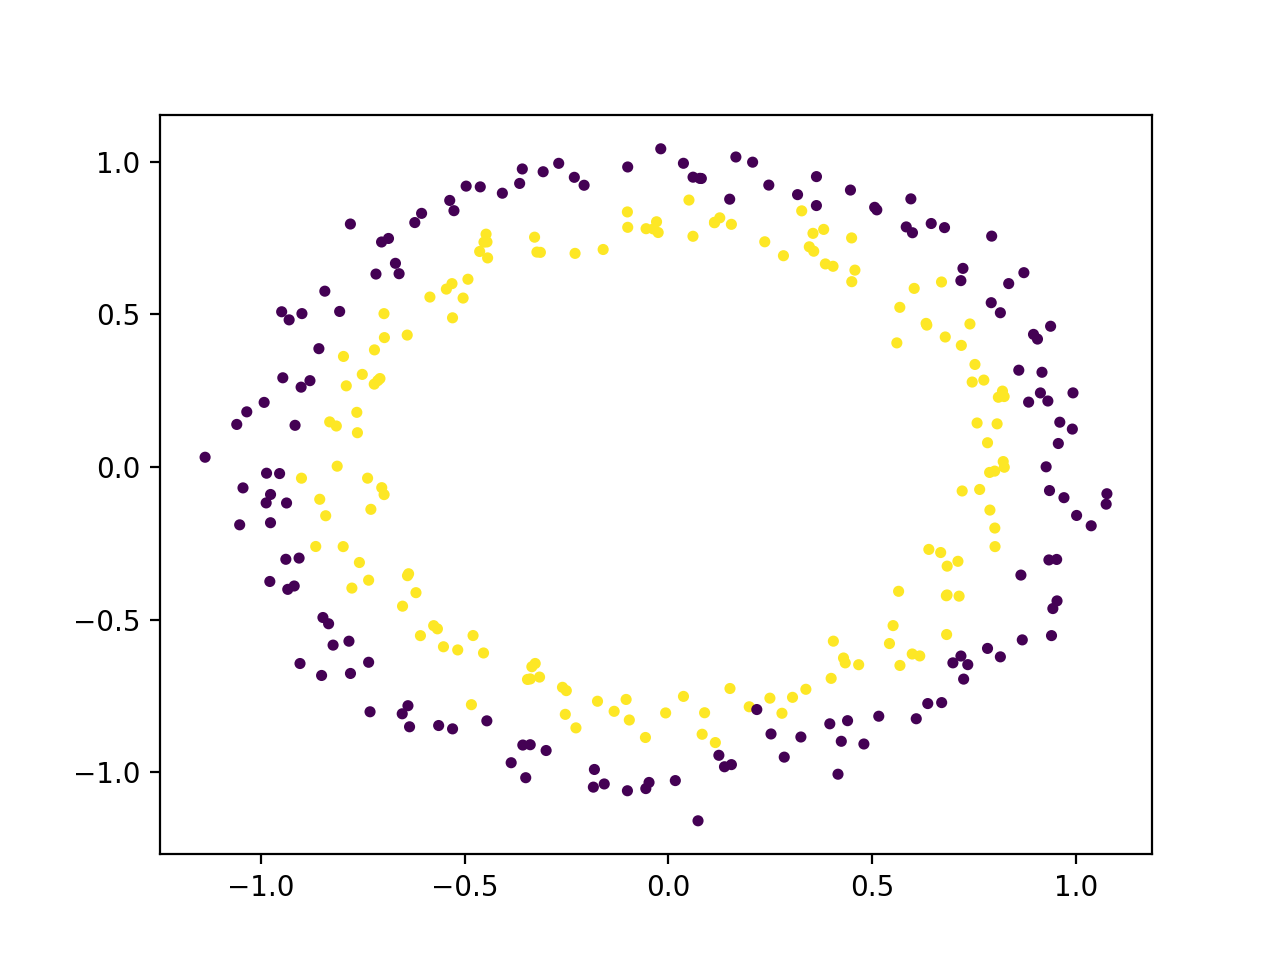

10
3
1.2124574335962943


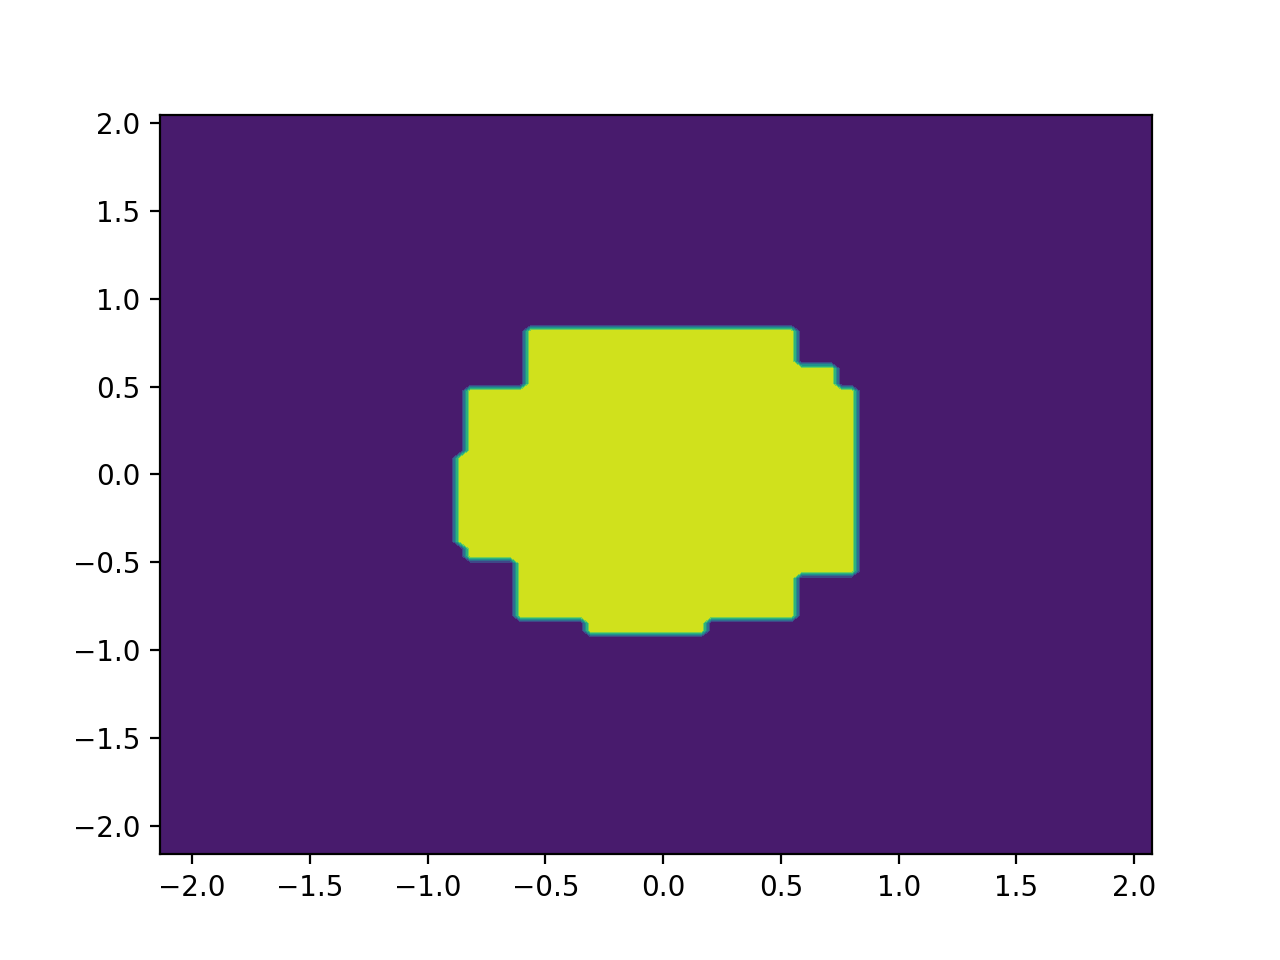

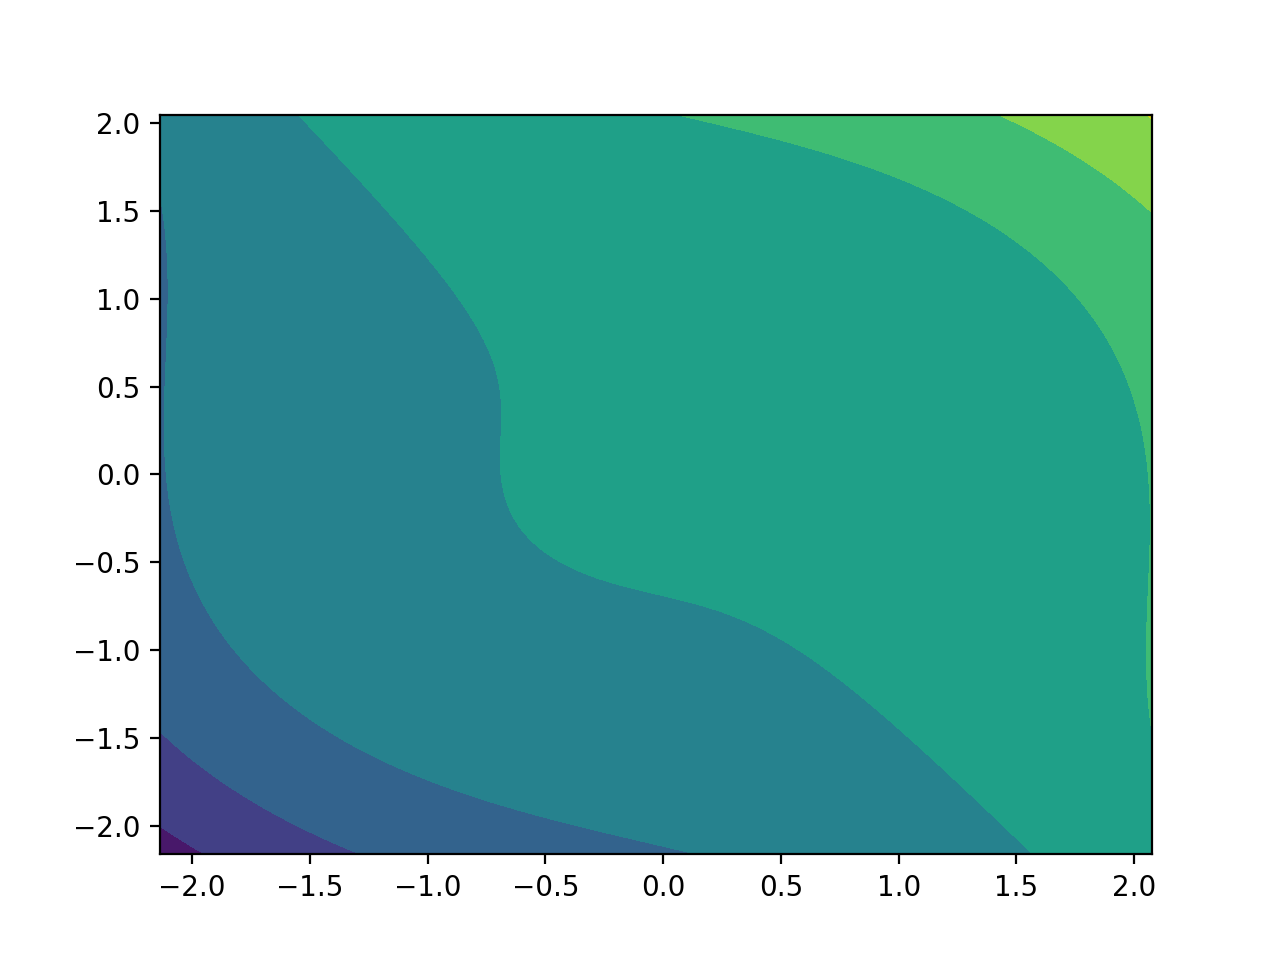

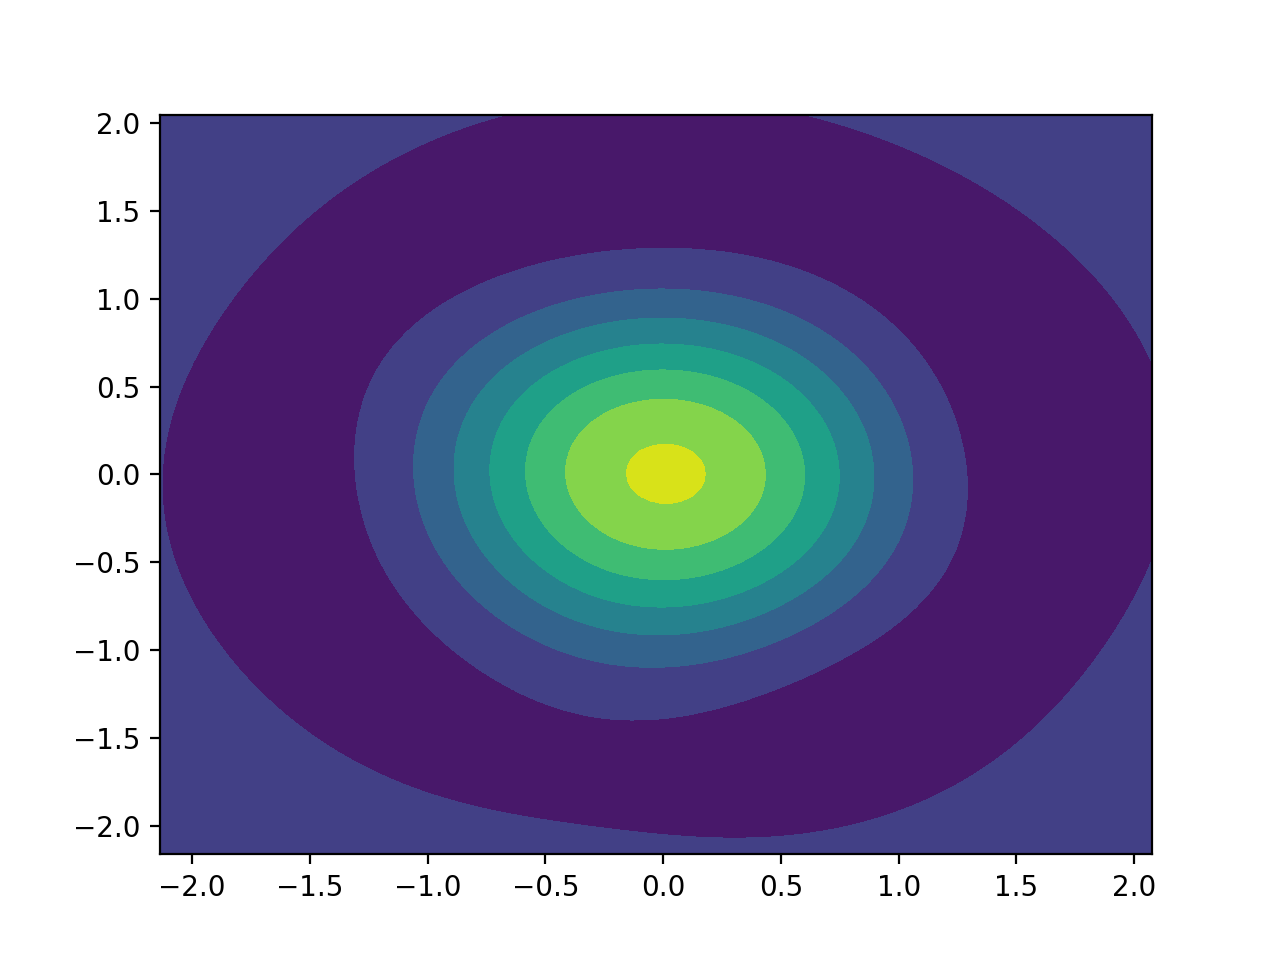

In [46]:
from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# generate synthetic dataset and plot
X, y = datasets.make_circles(n_samples=300, noise=0.05, random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=y, marker='.')
plt.show()

# build three classifiers
m1 = tree.DecisionTreeClassifier(random_state=123).fit(X, y)
m2 = SVC(random_state=123, kernel='poly').fit(X,y)
m3 = SVC(random_state=123, kernel='rbf').fit(X, y)

# plot decision boundaries
DecisionBoundaryDisplay.from_estimator(m1, X)
DecisionBoundaryDisplay.from_estimator(m2, X)
DecisionBoundaryDisplay.from_estimator(m3, X)

# default hyperparameters
print(m1.tree_.max_depth) # 10
print(m2.degree) # 3
print(m3._gamma) # 1.2124574335962943

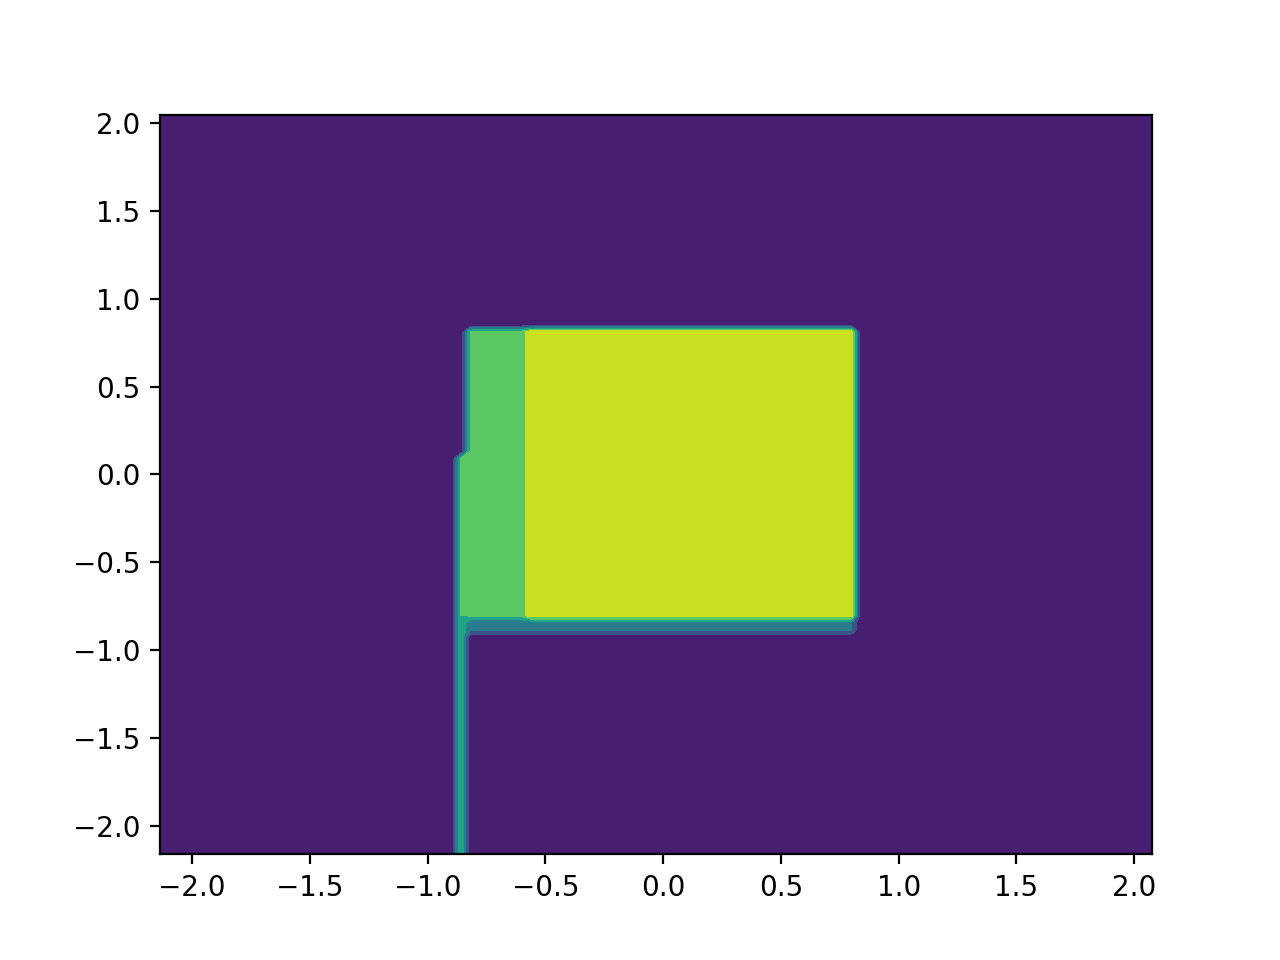

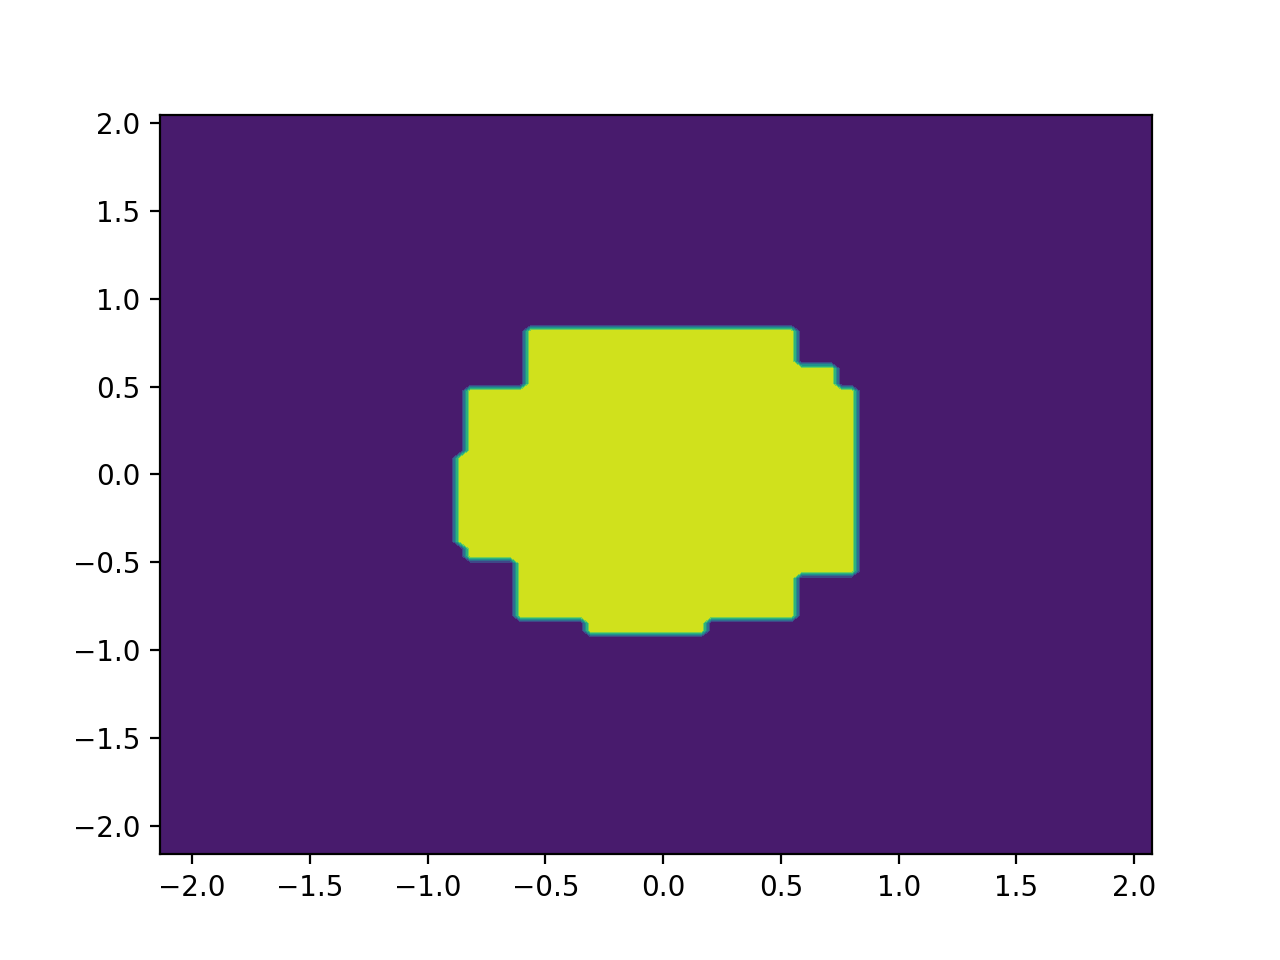

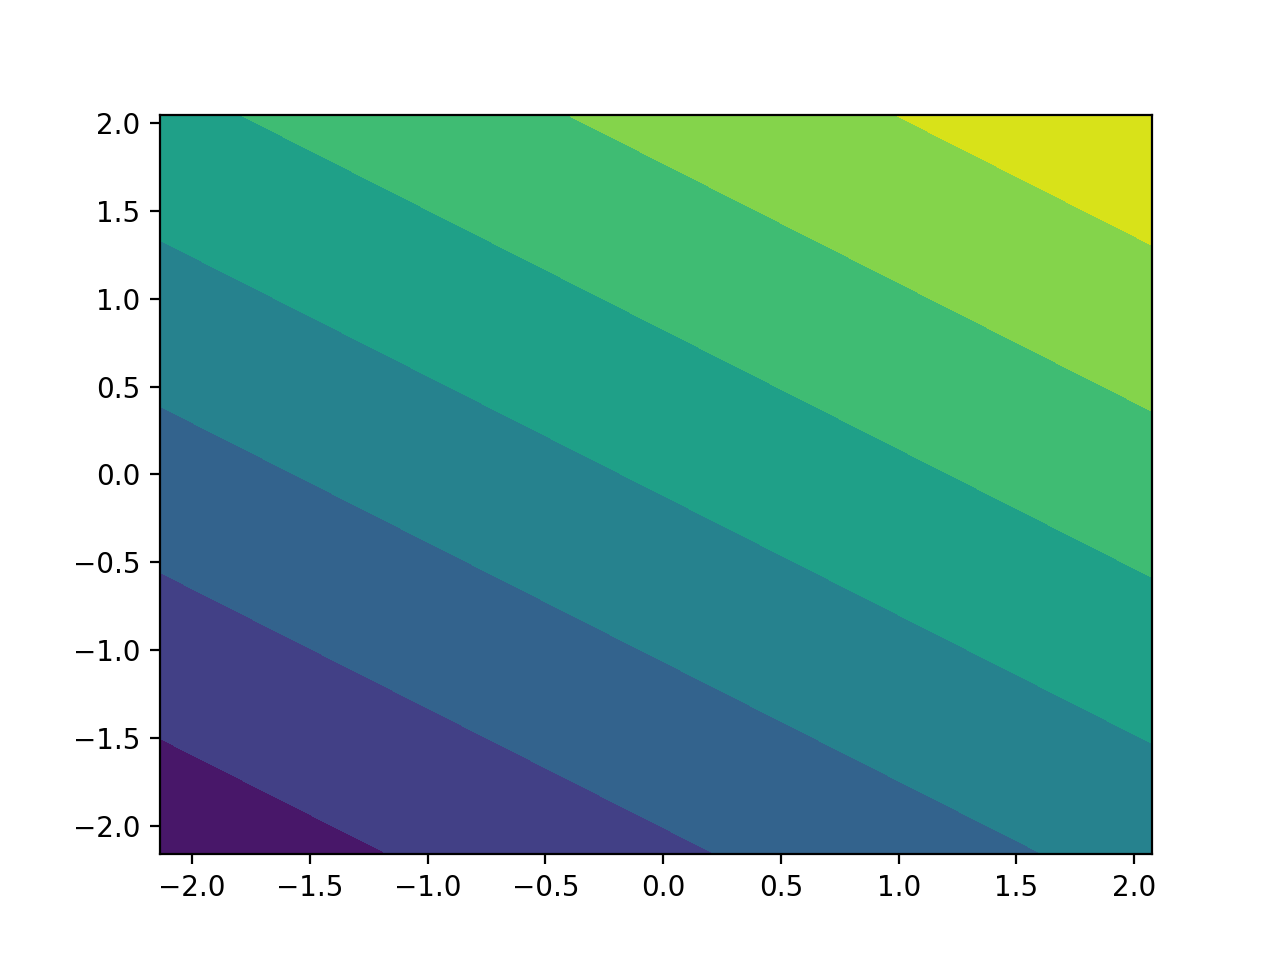

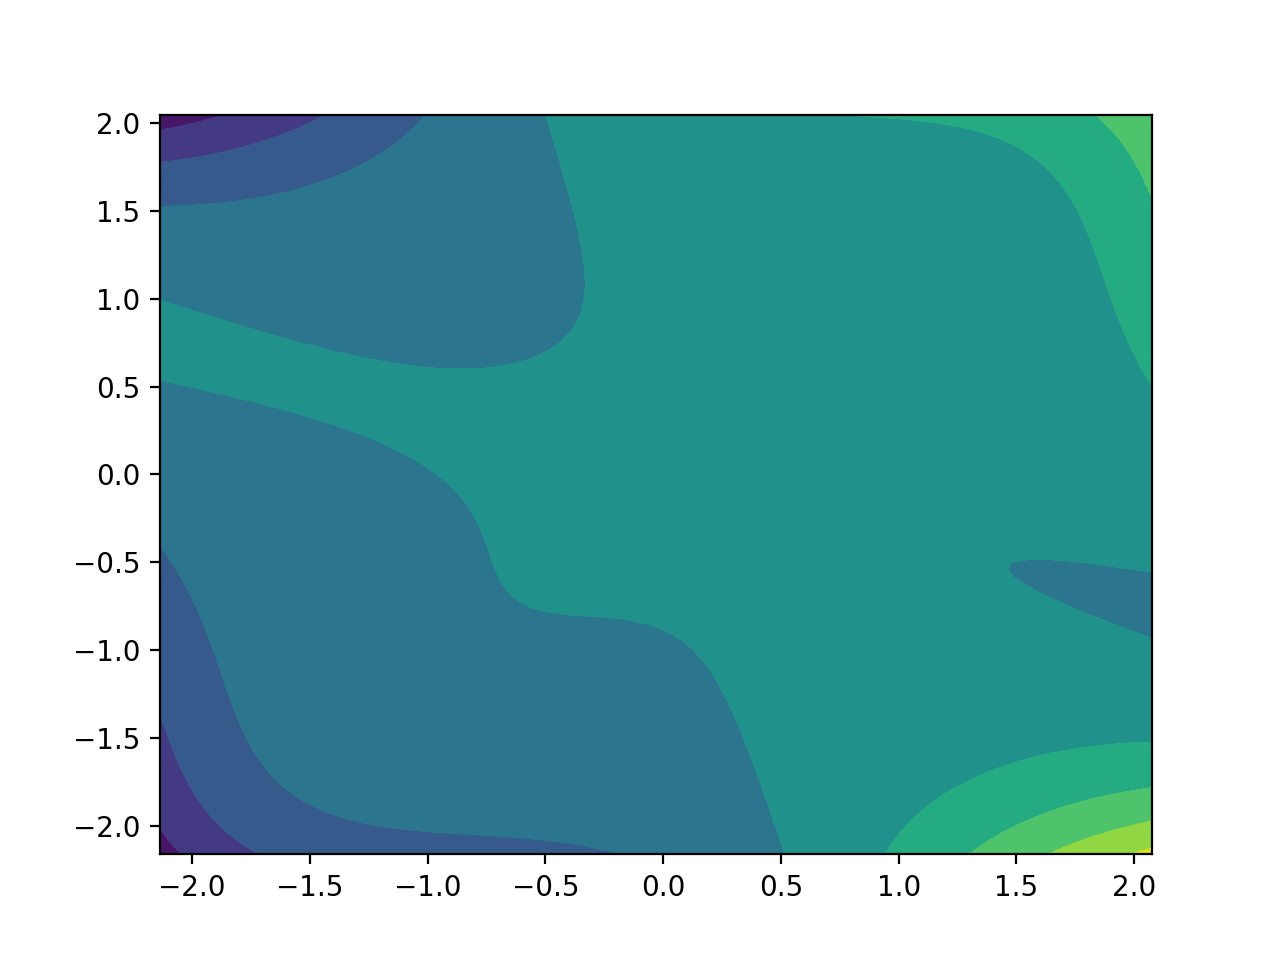

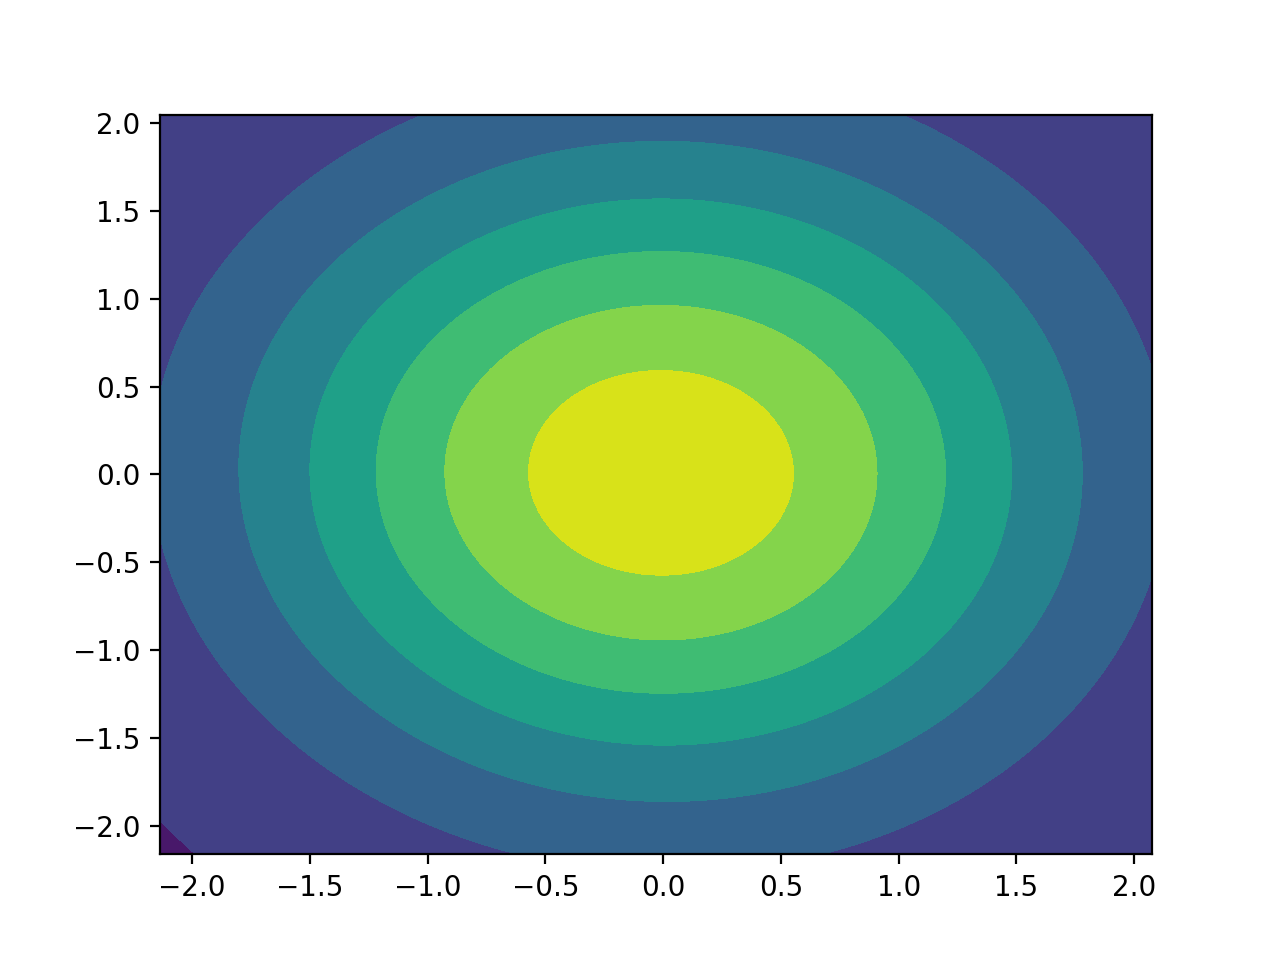

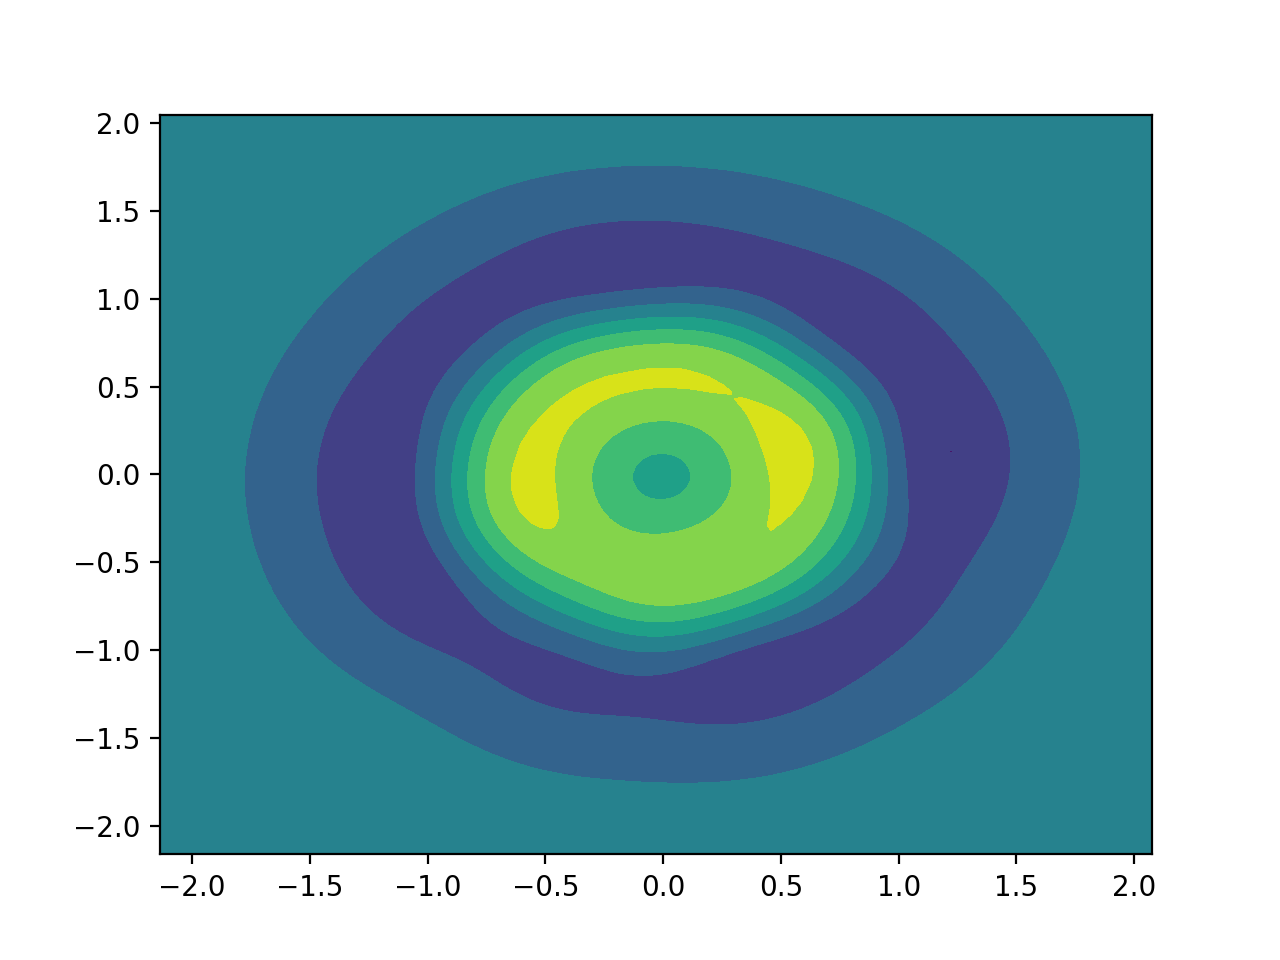

In [69]:

# Decision tree
m1_smaller = tree.DecisionTreeClassifier(max_depth=5, random_state=123).fit(X, y)
DecisionBoundaryDisplay.from_estimator(m1_smaller, X)
m1_larger = tree.DecisionTreeClassifier(max_depth=50, random_state=123).fit(X, y)
DecisionBoundaryDisplay.from_estimator(m1_larger, X)
# Decreasing max depth results in a simpler decision boundary with more uncertainty, which reduces overfitting.
# Increasing max deph higher than 10 does not seem to change anything in this case.

# SVM with polynomial kernel
m2_smaller = SVC(degree=1, random_state=123, kernel='poly').fit(X,y)
DecisionBoundaryDisplay.from_estimator(m2_smaller, X)
m2_larger = SVC(degree=5, random_state=123, kernel='poly').fit(X, y)
DecisionBoundaryDisplay.from_estimator(m2_larger, X)
# Lowering degrees results in a slightly simpler decision boundary.
# Increasing degrees makes decision boundary more comlex,
# which in training set gives better prediction measures, although it might cause overfitting.

# SVM with gaussian kernel
m3_smaller = SVC(gamma=0.2, random_state=123, kernel='rbf').fit(X, y)
DecisionBoundaryDisplay.from_estimator(m3_smaller, X)
m3_larger = SVC(gamma=5, random_state=123, kernel='rbf').fit(X, y)
DecisionBoundaryDisplay.from_estimator(m3_larger, X)
# Decreasing gamma results in a smoother decision boundary.
# Increasing gamma results in a more complex decision boundary,
# which is more sensitive to individual data points, so it may cause overfitting.

**10) Create an _unambiguous_ and _nontrivial_ question, and its corresponding solution, as if you were writing the set of exercises for the lab. The question must cover at least 3 of the following aspects:**

- **Logistic or multinomial regression classifiers**
- **Decision trees**
- **Bagging or random forests**
- **SVM**
- **Model evaluation**
- **Cross-validation or choice of hyperparameters**
- **Open-ended conceptual question to explain some behavior**

**Please make it explicit which 3 of these aspects your question covers. You can use any of the datasets available on Brightspace.**

In [32]:
## Predictive Modeling for Safety Perception

# Dataset: ams (neighborhood dataset)

# Objective:
# Build and evaluate predictive models to classify safety perception (saf_neighbors) in the given dataset.



import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split



# Lab Exercise Questions and Answers

# 1. Logistic Regression Model:
#    a. Create a binary response variable `y` based on the original variable `saf_neighbors`.
ams['y'] = ams['saf_neighbors'].cat.codes

#    b. Fit a logistic regression model (`m`) using the feature `hou_value`. Interpret the model summary, including coefficients and significance.
m = smf.glm('y ~ hou_value', ams, family=sm.families.Binomial()).fit()
print(m.summary())

# 2. SVM Classifier:
#    a. Implement an SVM classifier using the linear kernel on the dataset.
X_train, X_test, y_train, y_test = train_test_split(ams[['hou_value']], ams['saf_neighbors'], test_size=0.2, random_state=123)
svm_model = SVC(kernel='linear', C=1.0, random_state=123)
svm_model.fit(X_train, y_train)

#    b. Compare the classification performance (accuracy, precision, recall, F1 score) with the logistic regression model.
svm_predictions = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

#    c. Explore the impact of different hyperparameter choices for SVM.
kernel_types = ['linear', 'poly', 'rbf']
C_values = [0.1, 1.0, 10.0]

for kernel in kernel_types:
    for C_value in C_values:
        svm_model = SVC(kernel=kernel, C=C_value, random_state=123)
        svm_model.fit(X_train, y_train)
        svm_predictions = svm_model.predict(X_test)
        print(f"SVM - Kernel: {kernel}, C: {C_value}")
        print(classification_report(y_test, svm_predictions))

# 3. Open-Ended Conceptual Questions:
#    a. Propose and implement an SVM classifier, and assess its classification performance. Discuss any observed differences compared to the logistic regression model and suggest potential reasons.
# The SVM classifier with a linear kernel was implemented, and its performance was assessed. In comparison to the logistic regression model, the SVM showed similar accuracy but varied precision, recall, and F1-score values for different classes. The differences could be attributed to SVM's capability to capture non-linear relationships, potentially useful in scenarios where the data exhibits complex patterns.

#    b. Explore the impact of different hyperparameter choices for SVM. Try different kernel types and C parameters, observing their effects on classification performance.
# Hyperparameter tuning for the SVM involved experimenting with different kernel types (linear, polynomial) and C parameters. Notably, the linear kernel with varying C values resulted in relatively stable performance. However, the polynomial kernel, especially with lower C values, exhibited lower accuracy, emphasizing the importance of suitable hyperparameter choices.

#    c. Reflect on the choice of threshold in logistic regression and how adjusting it might influence classification outcomes. Consider the trade-off between sensitivity and specificity and its impact on false positives and false negatives.
threshold = 0.5
p = m.predict()
adjusted_p = ams['saf_neighbors'].cat.categories[np.where(p < threshold, 0, 1)]
print("Adjusted Logistic Regression Classification Report:")
print(classification_report(ams['saf_neighbors'], adjusted_p))
# Adjusting the threshold in logistic regression from the default 0.5 influenced classification outcomes. A higher threshold would increase specificity but decrease sensitivity, leading to more false negatives. Conversely, a lower threshold would increase sensitivity but decrease specificity, leading to more false positives. The choice depends on the application context; in safety perception, prioritizing sensitivity might be crucial to detect potential risks.


#    d. Discuss the concept of model interpretability, considering factors such as the linearity of logistic regression and the geometric interpretation of SVM. Reflect on which aspects of these models might be more interpretable in the context of predicting safety perception.
# Logistic regression is inherently more interpretable due to its linearity. Coefficients directly indicate the impact of features on the log-odds of the positive class. In contrast, SVM achieves interpretability through its margin and support vectors, providing a geometric interpretation. In the context of predicting safety perception, logistic regression's straightforward interpretation might be advantageous when the relationship is expected to be linear, while SVM's geometric insights could be valuable in capturing complex, non-linear patterns.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  413
Model:                            GLM   Df Residuals:                      411
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -247.07
Date:                Mon, 15 Jan 2024   Deviance:                       494.14
Time:                        15:56:40   Pearson chi2:                     394.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1002
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3292      0.343     -3.877      0.0

c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricW

SVM - Kernel: poly, C: 10.0
              precision    recall  f1-score   support

       1.low       0.00      0.00      0.00        34
      2.high       0.59      1.00      0.74        49

    accuracy                           0.59        83
   macro avg       0.30      0.50      0.37        83
weighted avg       0.35      0.59      0.44        83

SVM - Kernel: rbf, C: 0.1
              precision    recall  f1-score   support

       1.low       0.00      0.00      0.00        34
      2.high       0.59      1.00      0.74        49

    accuracy                           0.59        83
   macro avg       0.30      0.50      0.37        83
weighted avg       0.35      0.59      0.44        83

SVM - Kernel: rbf, C: 1.0
              precision    recall  f1-score   support

       1.low       0.00      0.00      0.00        34
      2.high       0.59      1.00      0.74        49

    accuracy                           0.59        83
   macro avg       0.30      0.50      0.37     

c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricW